In [2]:
import numpy as np
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

In [3]:
#Import all necessary package

In [4]:
from qiskit_nature.drivers import PySCFDriver
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem
from qiskit_nature.mappers.second_quantization import ParityMapper, BravyiKitaevMapper, JordanWignerMapper
from qiskit_nature.converters.second_quantization.qubit_converter import QubitConverter
from qiskit_nature.circuit.library import HartreeFock
from qiskit.circuit.library import TwoLocal
from qiskit_nature.circuit.library import UCCSD, PUCCD, SUCCD
from qiskit.circuit import Parameter, QuantumCircuit, QuantumRegister
from qiskit import Aer
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SPSA, SLSQP
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SPSA, SLSQP
from qiskit_nature.algorithms.ground_state_solvers.minimum_eigensolver_factories import NumPyMinimumEigensolverFactory
from qiskit_nature.algorithms.ground_state_solvers import GroundStateEigensolver
import numpy as np
from qiskit.algorithms import VQE
from IPython.display import display, clear_output
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller
import matplotlib.pyplot as plt
import pandas as pd
import os.path

In [5]:
backend = Aer.get_backend('statevector_simulator')
    
mapper_type = 'JordanWignerMapper'
if mapper_type == 'ParityMapper':
    mapper = ParityMapper()
elif mapper_type == 'JordanWignerMapper':
    mapper = JordanWignerMapper()
elif mapper_type == 'BravyiKitaevMapper':
    mapper = BravyiKitaevMapper()

optimizer_type = 'COBYLA'
if optimizer_type == 'COBYLA':
    optimizer = COBYLA(maxiter=500)
elif optimizer_type == 'L_BFGS_B':
    optimizer = L_BFGS_B(maxfun=500)
elif optimizer_type == 'SPSA':
    optimizer = SPSA(maxiter=500)
elif optimizer_type == 'SLSQP':
    optimizer = SLSQP(maxiter=500)

def exact_diagonalizer(problem, converter):
    solver = NumPyMinimumEigensolverFactory()
    calc = GroundStateEigensolver(converter, solver)
    result = calc.solve(problem)
    return result

def CreateAnsatz(ansatz_type,num_particles,num_spin_orbitals):
    # Put arguments for twolocal
    if ansatz_type == "TwoLocal":
        # Single qubit rotations that are placed on all qubits with independent parameters
        rotation_blocks = ['h','ry','rz','x','z']#I add h,rz,x gate
        # Entangling gates
        entanglement_blocks = 'cx'
        # How the qubits are entangled 
        entangler_map = [[0, 3], [1,2]]#Use for manually entangling
        entanglement = ['linear']# (orther option:'circular','sca')
        # Repetitions of rotation_blocks + entanglement_blocks with independent parameters
        repetitions = 1
        # Skip the final rotation_blocks layer
        skip_final_rotation_layer = False
        ansatz = TwoLocal(qubit_op.num_qubits, rotation_blocks, entanglement_blocks, reps=repetitions, 
                          entanglement=entanglement, skip_final_rotation_layer=skip_final_rotation_layer)
        # Add the initial state
        ansatz.compose(init_state, front=True, inplace=True)
    elif ansatz_type == "UCCSD":
        ansatz = UCCSD(converter,num_particles,num_spin_orbitals,initial_state = init_state)
    elif ansatz_type == "PUCCD":
        ansatz = PUCCD(converter,num_particles,num_spin_orbitals,initial_state = init_state)
    elif ansatz_type == "SUCCD":
        ansatz = SUCCD(converter,num_particles,num_spin_orbitals,initial_state = init_state)
    elif ansatz_type == "Custom":
        # Define the variational parameter
        theta = Parameter('a')
        n = qubit_op.num_qubits
        # Make an empty quantum circuit
        qc = QuantumCircuit(qubit_op.num_qubits)
        qubit_label = 0
        # Place a Hadamard gate
        qc.h(qubit_label)
        # Place a CNOT ladder
        for i in range(n-3):
            qc.cx(i+1, i+2)
        # Visual separator
        qc.barrier()
        # rz rotations on all qubits
        qc.rz(theta, range(n))
        qc.ry(theta1, range(n))
        ansatz = qc
        ansatz.compose(init_state, front=True, inplace=True)
    return ansatz
counts = []
values = []
params = []
deviation = []
def callback(eval_count, parameters, mean, std):  
    # Overwrites the same line when printing
    display("Evaluation: {}, Energy: {}, Std: {}".format(eval_count, mean, std))
    clear_output(wait=True)
    counts.append(eval_count)
    values.append(mean)
    params.append(parameters)
    deviation.append(std)
    
def Scoring(result,ansatz_type):
    pass_ = Unroller(['u', 'cx'])
    pm = PassManager(pass_)
    ansatz_tp = pm.run(ansatz)
    cnots = ansatz_tp.count_ops()['cx']
    score = cnots
    accuracy_threshold = 4.0 # in mHa
    energy = result.optimal_value

    if ansatz_type == "TwoLocal":
        rotation_blocks = ['ry', 'rz']
        entanglement_blocks = 'cx'
        entanglement = 'full'
        repetitions = 3
        skip_final_rotation_layer = True
        result_dict = {
            'optimizer': optimizer.__class__.__name__,
            'mapping': converter.mapper.__class__.__name__,
            'ansatz': ansatz.__class__.__name__,
            'rotation blocks': rotation_blocks,
            'entanglement_blocks': entanglement_blocks,
            'entanglement': entanglement,
            'repetitions': repetitions,
            'skip_final_rotation_layer': skip_final_rotation_layer,
            'energy (Ha)': energy,
            'error (mHa)': (energy-exact_energy)*1000,
            'pass': (energy-exact_energy)*1000 <= accuracy_threshold,
            '# of parameters': len(result.optimal_point),
            'final parameters': result.optimal_point,
            '# of evaluations': result.optimizer_evals,
            'optimizer time': result.optimizer_time,
            '# of qubits': int(qubit_op.num_qubits),
            '# of CNOTs': cnots,
            'score': score}
    else:
        result_dict = {
            'optimizer': optimizer.__class__.__name__,
            'mapping': converter.mapper.__class__.__name__,
            'ansatz': ansatz.__class__.__name__,
            'rotation blocks': None,
            'entanglement_blocks': None,
            'entanglement': None,
            'repetitions': None,
            'skip_final_rotation_layer': None,
            'energy (Ha)': energy,
            'error (mHa)': (energy-exact_energy)*1000,
            'pass': (energy-exact_energy)*1000 <= accuracy_threshold, #accuract_thres
            '# of parameters': len(result.optimal_point),
            'final parameters': result.optimal_point,
            '# of evaluations': result.optimizer_evals,
            'optimizer time': result.optimizer_time,
            '# of qubits': int(qubit_op.num_qubits),
            '# of CNOTs': cnots,
            'score': score}
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(1, 1)
    ax.set_xlabel('Iterations')
    ax.set_ylabel('Energy')
    ax.grid()
    fig.text(0.7, 0.75, f'Energy: {result.optimal_value:.3f}\nScore: {score:.0f}')
    plt.title(f"{result_dict['optimizer']}-{result_dict['mapping']}\n{result_dict['ansatz']}")
    ax.plot(counts, values)
    ax.axhline(exact_energy, linestyle='--')
    fig_title = f"\
    {result_dict['optimizer']}-\
    {result_dict['mapping']}-\
    {result_dict['ansatz']}-\
    Energy({result_dict['energy (Ha)']:.3f})-\
    Score({result_dict['score']:.0f})\
    .png"
    fig.savefig(fig_title, dpi=300)

    # Display and save the data
    filename = 'results4.csv'
    if os.path.isfile(filename):
        result_df = pd.read_csv(filename)
        result_df = result_df.append([result_dict])
    else:
        result_df = pd.DataFrame.from_dict([result_dict])
        
    result_df.to_csv(filename)
    return result_df

In [6]:
# WRITE YOUR CODE BETWEEN THESE LINES - START
# Running SCF
molecule = 'Li 0.0 0.0 0.0; H 0.0 0.0 1.5474'
#1.5474
# molecule = "H .0 .0 .0; H .0 .0 0.739"

driver = PySCFDriver(atom=molecule)
qmolecule = driver.run()
n_el = qmolecule.num_alpha + qmolecule.num_beta
n_mo = qmolecule.num_molecular_orbitals
n_so = 2 * qmolecule.num_molecular_orbitals
n_q = 2* qmolecule.num_molecular_orbitals
e_nn = qmolecule.nuclear_repulsion_energy
print(n_el,n_mo,n_so,n_q,e_nn)
# CoreFreezing: don't count the core electrons, because they do not translate to orther energy level
from qiskit_nature.transformers import FreezeCoreTransformer
#orbital can be remove: 2,3,4,5
Transformer = FreezeCoreTransformer(freeze_core=True,remove_orbitals=[3,4]) #I remove orbital 3,4 because they do not contribute so mmuch
qmolecule = Transformer.transform(qmolecule)
n_el = qmolecule.num_alpha + qmolecule.num_beta
n_mo = qmolecule.num_molecular_orbitals
n_so = 2 * qmolecule.num_molecular_orbitals
n_q = 2* qmolecule.num_molecular_orbitals
e_nn = qmolecule.nuclear_repulsion_energy
print(n_el,n_mo,n_so,n_q,e_nn)
# Second quantization
problem = ElectronicStructureProblem(driver,q_molecule_transformers=[Transformer])
second_q_ops = problem.second_q_ops()
main_op = second_q_ops[0]

4 6 12 12 1.0259348796432726
2 3 6 6 1.0259348796432726


(1, 1) 6
Exact electronic energy -1.0887060157347388
Initial state = 
     ┌───┐
q_0: ┤ X ├
     ├───┤
q_1: ┤ X ├
     └───┘
q_2: ─────
          
q_3: ─────
          
Number of cnot =  3


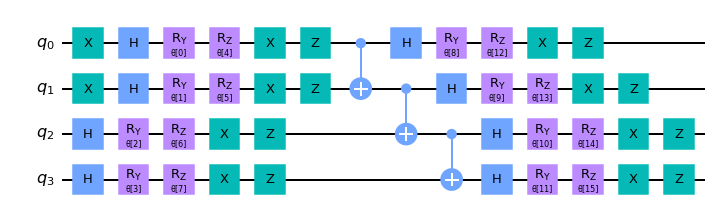

In [7]:
# Qubit mapping
mapper = ParityMapper() #JordanWignerMapper
converter = QubitConverter(mapper=mapper, two_qubit_reduction=True, z2symmetry_reduction = [-1,1]) #z2symmetry_reduction =[-1,1]
num_particles = (problem.molecule_data_transformed.num_alpha,
             problem.molecule_data_transformed.num_beta)
qubit_op = converter.convert(main_op, num_particles=num_particles)
# Initial state
num_spin_orbitals = 2 * problem.molecule_data_transformed.num_molecular_orbitals
init_state = HartreeFock(num_spin_orbitals, num_particles, converter)
# Ansatz
ansatz_type = "TwoLocal"
# for ansatz_type in ['TwoLocal','UCCSD','PUCCD','SUCCD',"Custom"]:
num_particles = (problem.molecule_data_transformed.num_alpha,
             problem.molecule_data_transformed.num_beta)
num_spin_orbitals = 2 * problem.molecule_data_transformed.num_molecular_orbitals
print(num_particles, num_spin_orbitals)
ansatz = CreateAnsatz(ansatz_type,num_particles,num_spin_orbitals)
# Exact diagonalization
result_exact = exact_diagonalizer(problem, converter)
exact_energy = np.real(result_exact.eigenenergies[0])
print("Exact electronic energy", exact_energy)
print("Initial state = ")
print(init_state)
print('Number of cnot = ',ansatz.count_ops()['cx'])
ansatz.draw()

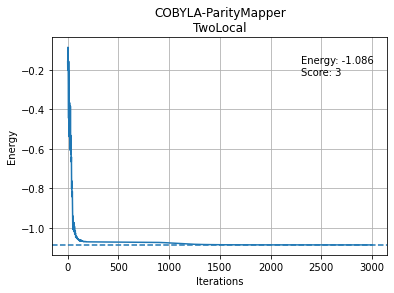

In [8]:
# Variational quantum eigensolver
try:
    initial_point = [0.01] * len(ansatz.ordered_parameters)
except:
    initial_point = [0.01] * ansatz.num_parameters

optimizer = COBYLA(maxiter=3000,tol=1e-4)
# optimizer_type = 'COBYLA'
# if optimizer_type == 'COBYLA':
#     optimizer = COBYLA(maxiter=500)
# elif optimizer_type == 'L_BFGS_B':
#optimizer = L_BFGS_B(maxfun=500)
# elif optimizer_type == 'SPSA':
#     optimizer = SPSA(maxiter=500)
# elif optimizer_type == 'SLSQP':
#     optimizer = SLSQP(maxiter=500)
algorithm = VQE(ansatz,
                optimizer=optimizer,
                quantum_instance=backend,
                callback=callback,
                initial_point=initial_point)

result = algorithm.compute_minimum_eigenvalue(qubit_op)
result_df = Scoring(result,ansatz_type)
# WRITE YOUR CODE BETWEEN THESE LINES - END

In [9]:
result_df[['optimizer' ,'ansatz','# of qubits', '# of parameters', 'error (mHa)','score']]

,optimizer,ansatz,# of qubits,# of parameters,error (mHa),score
0,COBYLA,TwoLocal,4,16,2.499651,3


In [10]:
# Check your answer using following code
from qc_grader import grade_ex5
freeze_core = True # change to True if you freezed core electrons
grade_ex5(ansatz,qubit_op,result,freeze_core)

Grading your answer for ex5. Please wait...

Congratulations 🎉! Your answer is correct.
Your cost is 3.
Feel free to submit your answer.

